# kmeans_correlate_cluster
- Using the distinct clusters of SDSS images generated by kmeans applied to CNN output, this evaluates the clusters relative to other derived parameters about the galaxies 
- Also creating a visualisation of clusters in the domain of common galaxy parameters

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import harry_plotter as hp
import matplotlib
from matplotlib.patches import ConnectionPatch
hp.default(matplotlib.rcParams)

### Loading in cluster labels and images 

In [2]:
# loading in pre-processed data
data_dir = '../../../sdss_CNN/data/cleaned_datasets/'
x = np.load(data_dir + 'x.npy')
pifu = np.load(data_dir + 'plateifu.npy') # needed to mask out missing images

# cluster tags
labels = np.load('../cluster_tags/KMeans-10_CNN-37632_PCA-100.npy')

### Loading in galaxy parameters (lambda_R and ellipicity)

In [3]:
# loading tab and masking on plateifu (already sorted so np.isin is fine)
tab = pd.read_csv('/Users/chrisduckworth/astronomy/projects/spin_bias/catalogues/manga.Pipe3D_v2_5_3.csv')
tab = tab[np.isin(tab.plateifu.values, pifu)]

### Ordering cluster labels in lambda_R to aid plotting 

In [5]:
# sorting cluster labels based on average lambda_R
cluster_cen = []

for ind in np.unique(labels):
    cluster_cen.append(np.median(tab.ellip.values[labels == ind]))

### Creating scatter plot of clusters in (shape-spin) phase space, with an example image for each defined cluster.

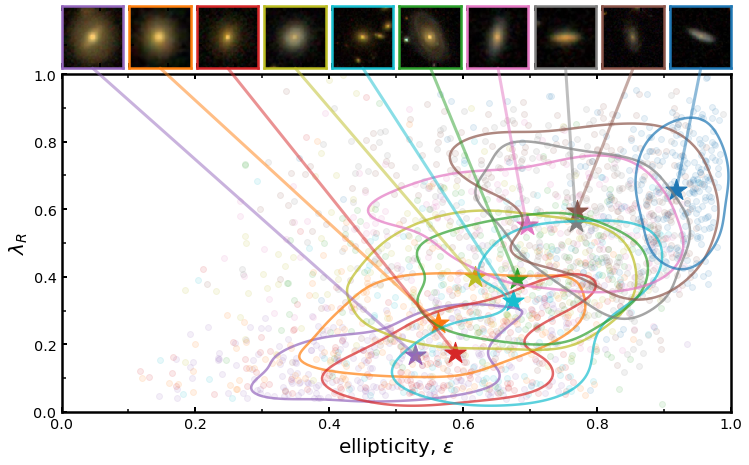

In [27]:
fig = plt.figure(figsize=(12, 10))
gs = matplotlib.gridspec.GridSpec(2, 10)

# adding axes for images
ax_scatter = fig.add_subplot(gs[1, :])

for count, ind in enumerate(np.argsort(np.array(cluster_cen))):
    
    # adding image subplot with cluster coloured outline
    ax = fig.add_subplot(gs[0, count])
    ax.imshow(x[np.argmax(labels == ind)])
    ax.spines['bottom'].set_color(sns.color_palette()[ind])
    ax.spines['top'].set_color(sns.color_palette()[ind]) 
    ax.spines['right'].set_color(sns.color_palette()[ind])
    ax.spines['left'].set_color(sns.color_palette()[ind])
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    
    ax_scatter.scatter(tab.ellip.values[labels == ind][::3], tab.lambda_re.values[labels == ind][::3], 
               color=sns.color_palette()[ind],
               alpha=0.1)
    
    ax_scatter.scatter(np.median(tab.ellip.values[labels == ind]), np.median(tab.lambda_re.values[labels == ind]), 
               label='Cluster {}'.format(ind),
               color=sns.color_palette()[ind],
               marker='*', s=500)
    
    sns.kdeplot(x=tab.ellip.values[labels == ind], y=tab.lambda_re.values[labels == ind], 
                levels=[0.5], 
                alpha=0.7,
                color=sns.color_palette()[ind], 
                ax=ax_scatter)
    
    con = ConnectionPatch(xyA=(40, 80), xyB=(np.median(tab.ellip.values[labels == ind]), np.median(tab.lambda_re.values[labels == ind])), 
                          coordsA="data", coordsB="data", linewidth=3, alpha=0.5,
                          axesA=ax, axesB=ax_scatter, color=sns.color_palette()[ind])
    ax.add_artist(con)

ax_scatter.set_xlim([0, 1])
ax_scatter.set_ylim([0, 1])

ax_scatter.set_xlabel('ellipticity, $\epsilon$', fontsize=20)
ax_scatter.set_ylabel('$\lambda_R$', fontsize=20)
#ax_scatter.legend(frameon=False, ncol=2, fontsize=14)

fig.subplots_adjust(wspace=0.1, hspace=-0.39)

hp.xtick_format(0.2, 0.1, format='%1.1f', ax=ax_scatter)
hp.ytick_format(0.2, 0.1, format='%1.1f', ax=ax_scatter)

plt.savefig('lambda_R_eps_kmeans_cluster.pdf', format='pdf', bbox_inches='tight')